In [1]:
import numpy as np
from ticktack import fitting
import ticktack
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
mpl.style.use('seaborn-colorblind')

## Generating the data (can ignored, data is already given in recover_SH.csv)

In [2]:
model = "Brehm21"
cbm = ticktack.load_presaved_model(model, production_rate_units='atoms/cm^2/s')
sf = fitting.SingleFitter(cbm, model, box="Troposphere", hemisphere='south')
sf.compile_production_model(model="flexible_sinusoid_affine_variant")

In [3]:
sf.time_data = np.arange(200, 230)
sf.d14c_data_error = np.ones((sf.time_data.size,))
sf.start = np.nanmin(sf.time_data)
sf.end = np.nanmax(sf.time_data)
sf.annual = np.arange(sf.start, sf.end + 1)
sf.oversample = 1008
sf.burn_in_time = np.arange(sf.start-2000, sf.start, 1.)
sf.time_data_fine = np.linspace(sf.start, sf.end + 2, (sf.annual.size + 1) * sf.oversample)
sf.offset = 0
sf.mask = np.in1d(sf.annual, sf.time_data)
sf.growth = sf.get_growth_vector("october-march")

In [4]:
sf.box_idx #box_idx is 1 for Brehm21 when the hemisphere is 'south', it is 12 for 'north'

1

In [5]:
params = np.array([-2.20263609e-03,  210,  2.55367316e-01,  3.28980240e+00,
        8.21112436e-01, -1.38787353e+00]) # data generating parameters

In [6]:
d14c = sf.dc14(params)

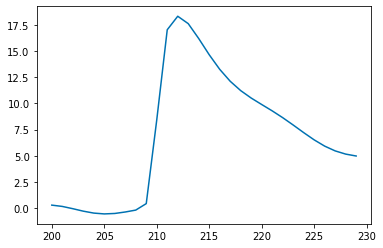

In [7]:
plt.plot(sf.time_data, d14c)

In [8]:
np.random.seed(0)

In [9]:
d14c_noise = d14c + np.random.randn(30)

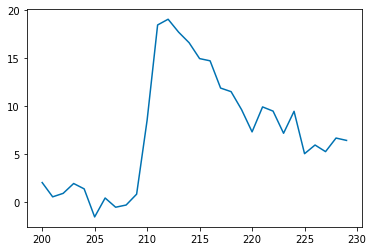

In [10]:
plt.plot(sf.time_data, d14c_noise)

In [11]:
df = pd.DataFrame(d14c_noise)

filepath = 'my_excel_file.csv'
df.to_csv(filepath, index=False)

In [12]:
d14c_noise

DeviceArray([ 2.05873335,  0.57058528,  0.93341581,  1.95956748,
              1.40256429, -1.52105665,  0.44913268, -0.51176517,
             -0.28193865,  0.84929286,  8.56174693, 18.47694496,
             19.07310737, 17.72875164, 16.62766072, 14.97245472,
             14.74148285, 11.90351706, 11.53030342,  9.65394784,
              7.33892698,  9.93976365,  9.50229895,  7.1940711 ,
              9.4809049 ,  5.06507568,  5.96899626,  5.28010229,
              6.69516368,  6.4494424 ], dtype=float64)

## Recovery process

In [13]:
model = "Brehm21"
cbm_recover = ticktack.load_presaved_model(model, production_rate_units='atoms/cm^2/s')
sf_recover = fitting.SingleFitter(cbm_recover, model, box="Troposphere", hemisphere="south")
sf_recover.load_data("recover.csv", oversample=1008, burnin_time=2000)
sf_recover.compile_production_model(model="flexible_sinusoid_affine_variant")

In [14]:
default_params = jnp.array([-1.00797052e-03,  2.10523473e+02, -3.35300358e-01,  3.85064256e+00,
        7.87839120e-01, -1.61086280e+00])
default_low_bounds = jnp.array([-1.76 * 0.05 / 5, 210 - 5, np.log10(4 / 52.), 0, -2, -2])
default_up_bounds = jnp.array([1.76 * 0.05 / 5, 210 + 5, np.log10(5.), 11, 1.5, 1.5])

In [15]:
chain = sf_recover.MarkovChainSampler(default_params,
                                          likelihood=sf_recover.log_joint_likelihood,
                                          burnin=1000,
                                          production=1000,
                                          args=(default_low_bounds, default_up_bounds))

Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:20<00:00,  2.63it/s]


Running production...


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:09<00:00,  2.71it/s]


In [18]:
np.mean(chain, axis=0)

array([-1.60367846e-03,  2.10386796e+02, -1.13398918e-01,  3.67553291e+00,
        8.15317045e-01, -1.63381652e+00])

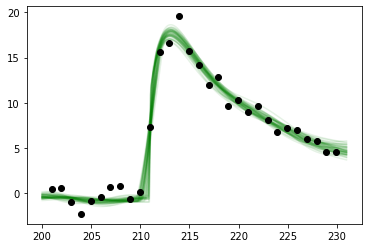

In [19]:
idx = np.random.randint(len(chain), size=50)
for i in idx:
    plt.plot(sf_recover.time_data_fine, sf_recover.dc14_fine(chain[i]), "g", alpha=0.1)

plt.plot(sf_recover.time_data + sf.time_offset, sf_recover.d14c_data, "ok")

In [20]:
params_truth = np.array([-2.20263609e-03,  210-205,  10**2.55367316e-01, 
                         10**8.21112436e-01/1.76, 3.28980240e+00, 10**-1.38787353e+00])

Text(0.5, 0.98, 'SH')

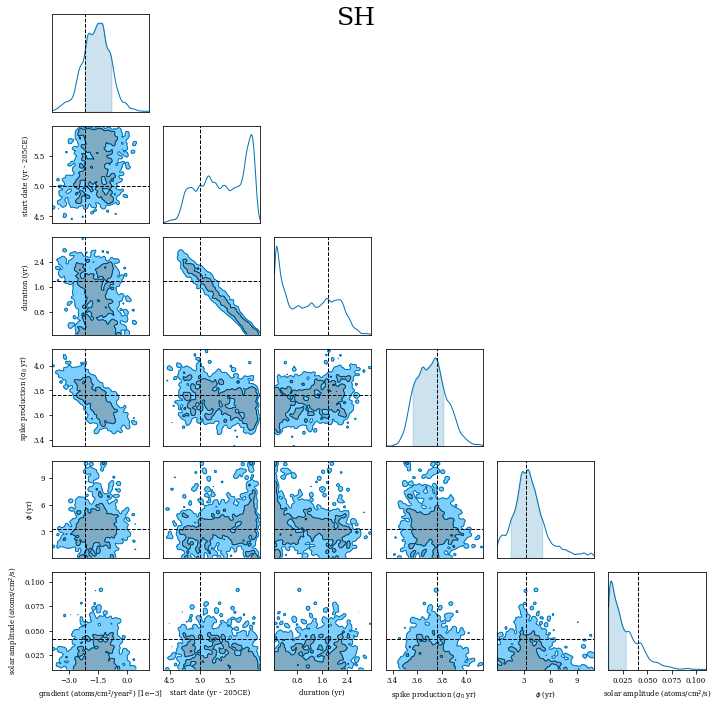

In [23]:
chain_copy = np.copy(chain) # making a copy of the chain, the plotting code will do operations on this copy  
start_date = "start date ({})".format("yr - " + str(int(210) - 5) + "CE")

chains = []
chains.append(chain_copy);

labels = ["gradient (atoms/cm$^2$/year$^2$)", start_date, "duration (yr)", "spike production ($q_0$ yr)", "$\phi$ (yr)", "solar amplitude (atoms/cm$^2$/s)"]
idx = 1
spike_idx  = 4
for i in range(len(chains)):
    chains[i][:, 2] = 10**chains[i][:, 2]
    chains[i][:, -1] = 10 ** chains[i][:, -1]
    chains[i][:, -2] = 10 ** chains[i][:, -2] / 1.76


for c in chains:
    c[:, idx] = c[:, idx] - (210 - 5)
    spike = c.copy()[:, spike_idx]
    c[:, spike_idx] = c[:, spike_idx - 1]
    c[:, spike_idx - 1] = spike

colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']
cf = fitting.CarbonFitter()
fig = cf.plot_multiple_chains(chains, chain.shape[1] * 2,
                        params_labels=labels,
                        label_font_size=7,
                        tick_font_size=7, colors=colors, max_ticks=4, legend=False, truth=params_truth
                        )

font = font_manager.FontProperties(family='serif', size=14)
# custom_lines = [Line2D([0], [0], color=colors[i], lw=0, label=["NH", "SH"][i]) for i in range(len(["NH", "SH"]))]
ax = fig.get_axes()[5]
# legend = ax.legend(handles=custom_lines, frameon=False, labelcolor=colors,
#                    prop=font, loc="upper right", bbox_to_anchor=(1, 0.5))
plt.suptitle("SH", fontsize=25)

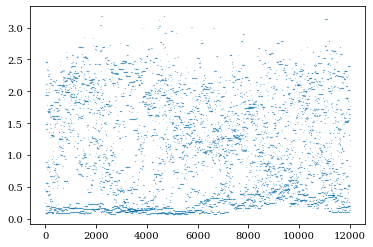

In [27]:
plt.plot(10**chain[:, 2], ".", markersize=0.2)

In [25]:
sf_recover.log_likelihood(params)

DeviceArray(-12.88520822, dtype=float64)

In [26]:
sf_recover.log_likelihood(np.mean(chain, axis=0))

DeviceArray(-17.6596003, dtype=float64)